In [1]:
import sys
sys.path.append('../scripts/')
from qmdp import *
from sensor_reset_mcl import *

In [13]:
class PfcAgent(QmdpAgent): ###pfc
    def __init__(self, time_interval, estimator, goal, puddles, sampling_num=10, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        super().__init__(time_interval, estimator, goal, puddles, sampling_num, widths, puddle_coef, lowerleft, upperright)

    def qpfc(self, action, indexes, current_value, power):
        return sum([self.dp.action_value(action, i, out_penalty=False)/(abs(self.dp.value_function[i])**power) for i in indexes])/len(indexes)
        
    def policy(self, pose, goal=None):
        for p in self.estimator.particles:
            if self.goal.inside(p.pose): p.weight *= 0.1
        self.estimator.resampling()
        
        indexes = [self.to_index(p.pose, self.pose_min, self.index_nums, self.widths) for p in self.estimator.particles]
        self.current_value = sum([self.dp.value_function[i] for i in indexes])/len(indexes)
        self.evaluations = [self.qpfc(a, indexes, self.current_value, 2) for a in self.dp.actions]
    
        self.history.append(self.dp.actions[np.argmax(self.evaluations)])
        
        if self.history[-1][0] + self.history[-2][0] == 0.0 and self.history[-1][1] + self.history[-2][1] == 0.0: #2回の行動で停止していたら前進
            return (1.0, 0.0)

        return self.history[-1]

<IPython.core.display.Javascript object>


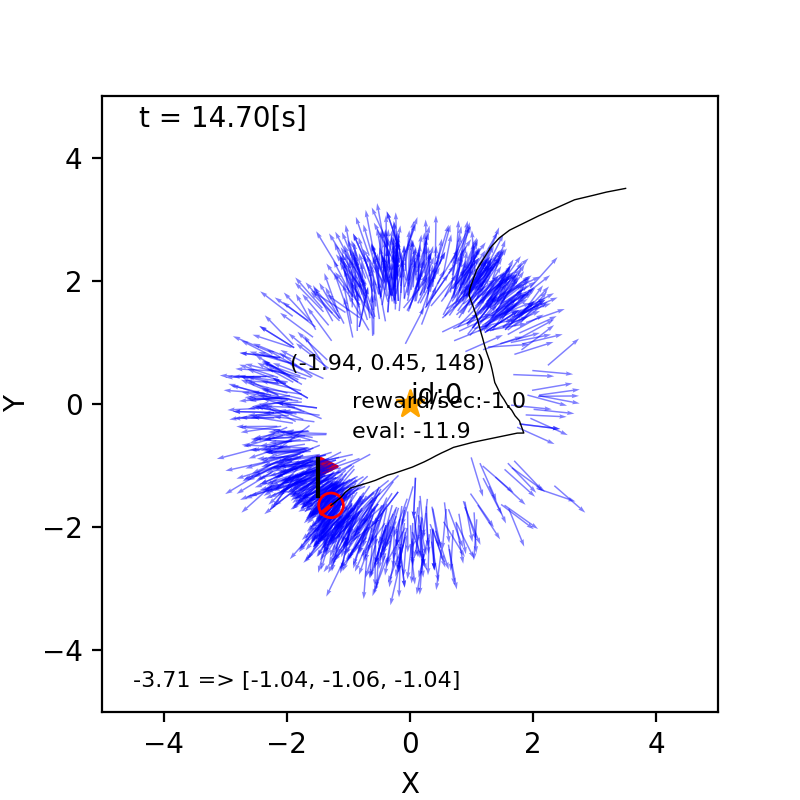

In [17]:
def trial(animation):
    time_interval = 0.1
    world = PuddleWorld(300, time_interval, debug=not animation) 

    ##ランドマークの追加（1個だけ）##
    m = Map()
    m.append_landmark(Landmark(0,0))
    world.append(m) 
    
    ##ゴール##
    goal = Goal(-1.5,-1.5)
    world.append(goal)
    
    ##ロボットを作る##
    init_pose = np.array([3.5, 3.5, np.pi]).T
    pf = ResetMcl(m, [-10, -10, 0], 1000)              #誘拐状態から始める（すぐセンサリセットされる）
    a = PfcAgent(time_interval, pf, goal, [])
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")

    world.append(r)
    world.draw()
    
trial(True)